# Rolling risk control - a simple example on a real dataset

In this notebook, we apply rolling risk control (RRC) on a real dataset to control the miscoverage loss and examine its outputs. Then, we run RRC once again to control a different loss function --- the *miscoverage counter* loss. 

We see that in both cases RRC controls the specified loss at the desired level, as guaranteed by Theorem 1.

# Imports

In [1]:
import sys

from tabulate import tabulate

sys.path.insert(0, "../")
import torch
from src.calibration.rolling_risk_control import RollingRiskControl
from src.calibration.set_constructing_functions.set_constructing_function import PredictionIntervalConstructingFunctionWithCQR
import matplotlib.pyplot as plt
from src.main_tabular import get_best_hyperparams
from src.utils import set_seeds
from typing import List
from tqdm import tqdm
import matplotlib
from src.losses import MiscoverageCounterLoss
from src.calibration.stretching_functions.stretching_functions import ExponentialStretching
from src.losses import MiscoverageLoss
from src.data_utils.datasets.regression_dataset import RegressionDataset
from src.data_utils.data_utils import DataType
from src.data_utils.get_dataset_utils import get_real_regression_dataset
from src.models.online_qr import OnlineQR

from src.data_utils.datasets.dataset import Dataset
from src.uncertainty_quantifiers.prediction_interval import PredictionIntervalsCollection
from src.calibration.online_calibration import OnlineCalibration
from src.models.abstract_models.online_learning_model import OnlineLearningModel
from src.uncertainty_quantifiers.prediction_interval import PredictionInterval
from src.calibration.parameters_free_online_calibration import ParameterFreeOnlineCalibration
from src.losses import compute_average_miscoverage_streak_length


font = {'size'   : 16}

matplotlib.rc('font', **font)

device_name = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)


import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

set_seeds(0)

%load_ext autoreload
%autoreload 2

# Definitions

In [2]:
# general definitions
alpha = 0.1
loss_to_control = MiscoverageLoss()

# dataset definitions
dataset_name = 'wind'
data_path = '../src/datasets/real_data'
backward_size = 3
max_data_size = 20000
test_ratio = 0.2
validation_ratio = 0.2


# model definitions
train_all_q = False
lstm_layers = 1
dropout = 0.1
wd = 0.
non_linearity = 'lrelu'
bs = 1
hp = get_best_hyperparams(train_all_q, dataset_name, "../src/hyperparameters.json")
lstm_hidden_size = hp['lstm_hidden_size']
lstm_in_layers = hp['lstm_in_layers']
lstm_out_layers = hp['lstm_out_layers']
lr = hp['lr']

# calibration scheme definitions
stretching = ExponentialStretching()
gamma = 0.05

# Initialize **dataset**, **model** and **calibration scheme**

In [3]:
x, y = get_real_regression_dataset(dataset_name, data_path)
dataset = RegressionDataset(x, y, backward_size, max_data_size, 0,
                         test_ratio, validation_ratio, DataType.Real, dataset_name, device)

In [4]:

model = OnlineQR(dataset.x_dim, dataset.y_dim,
                     lstm_hidden_size=lstm_hidden_size,
                     lstm_layers=lstm_layers, lstm_in_layers=lstm_in_layers,
                     lstm_out_layers=lstm_out_layers, dropout=dropout,
                     lr=lr, wd=wd, device=device, non_linearity=non_linearity,
                     backward_size=backward_size, train_all_q=train_all_q,
                     alpha=alpha, batch_size=bs)

In [5]:
set_constructing_function = PredictionIntervalConstructingFunctionWithCQR(stretching)
calibration_scheme = RollingRiskControl(gamma, alpha, set_constructing_function, loss_to_control)

# Online inference

In [8]:
def online_inference(model: OnlineLearningModel, calibration_scheme: OnlineCalibration,
                     dataset: Dataset, timestamps: List[int], device):
    uncertainty_set_collection = PredictionIntervalsCollection(len(timestamps), dataset.scaler, device)
    model_predictions = []
    for curr_timestamp in tqdm(timestamps):
        inference_sample = dataset.get_inference_sample(curr_timestamp)
        with torch.no_grad():
            model_prediction = model.predict(inference_sample)
            model_predictions.append(model_prediction)
            calibrated_uncertainty_set = calibration_scheme.calibrate(inference_sample, model_prediction)
            uncertainty_set_collection.add_uncertainty_sets(calibrated_uncertainty_set)

            labeled_inference_sample = dataset.get_labeled_inference_sample(curr_timestamp)
            calibration_scheme.update(labeled_inference_sample, model_prediction, calibrated_uncertainty_set, curr_timestamp)

        train_sample = dataset.get_train_sample(curr_timestamp)
        model.online_fit(train_sample)
    
    return uncertainty_set_collection, model_predictions


In [9]:
train_timestamps, validation_timestamps, test_timestamps = dataset.get_data_timestamps()

print("Running on training set...")
online_inference(model, calibration_scheme, dataset, train_timestamps, device)
print("Running on validation set...")
online_inference(model, calibration_scheme, dataset, validation_timestamps, device)
if isinstance(calibration_scheme, ParameterFreeOnlineCalibration):
    calibration_scheme.set_hyperparameters_on_validation_set(validation_timestamps)
print("Running on test set...")
calibrated_intervals, uncalibrated_intervals = online_inference(model, calibration_scheme, dataset, test_timestamps,
                 device)

uncalibrated_predictions = PredictionIntervalsCollection(len(test_timestamps), dataset.scaler, device)
for interval in uncalibrated_intervals:
    uncalibrated_predictions.add_uncertainty_sets(PredictionInterval(interval.intervals))
uncalibrated_intervals = uncalibrated_predictions

  0%|                                                                                | 4/12000 [00:00<05:18, 37.62it/s]

Running on training set...


  0%|▏                                                                               | 10/4000 [00:00<00:42, 93.49it/s]

Running on validation set...


  0%|▏                                                                                | 8/4000 [00:00<00:52, 76.58it/s]

Running on test set...


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:43<00:00, 92.40it/s]


# Visualize results

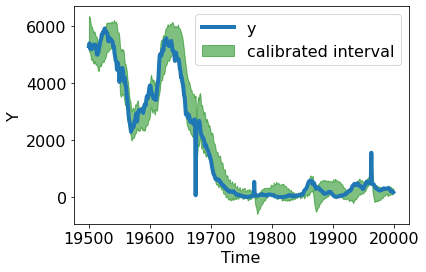

In [10]:
def visualize_results(dataset, timestamps, calibrated_intervals):
    y_test = dataset.unscaled_y.cpu().squeeze()[timestamps]
    predicted_intervals = calibrated_intervals.unscaled_intervals.squeeze()
    lower_pred, upper_pred = predicted_intervals[:, 0].cpu(), predicted_intervals[:, 1].cpu()

    fig, ax = plt.subplots()
    ax.plot(timestamps,y_test, linewidth=4, label='y')
    ax.fill_between(timestamps, lower_pred, upper_pred, color='green', alpha=.5, label='calibrated interval')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Y")
    plt.show()

size = 500
timestamps = test_timestamps[-size:]
visualize_results(dataset, timestamps, calibrated_intervals[-size:])

## Calibrated (green) vs uncalibrated intervals (blue)

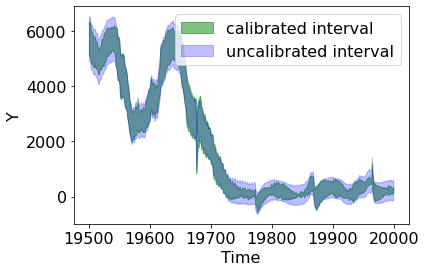

In [11]:
def visualize_intervals_comparison(dataset, timestamps, calibrated_intervals, uncalibrated_intervals):
    y_test = dataset.unscaled_y.cpu().squeeze()[timestamps]
    predicted_intervals = calibrated_intervals.unscaled_intervals.squeeze()
    lower_pred, upper_pred = predicted_intervals[:, 0].cpu(), predicted_intervals[:, 1].cpu()

    predicted_unscaled_intervals = uncalibrated_intervals.unscaled_intervals.squeeze()
    uncal_lower_pred, uncal_upper_pred = predicted_unscaled_intervals[-size:, 0].cpu(),\
                                            predicted_unscaled_intervals[-size:, 1].cpu()

    fig, ax = plt.subplots()
    ax.fill_between(timestamps, lower_pred, upper_pred, color='green', alpha=.5, label='calibrated interval')
    ax.fill_between(timestamps, uncal_lower_pred, uncal_upper_pred, color='blue', alpha=.25, label='uncalibrated interval')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Y")
    plt.show()
    
size = 500
timestamps = test_timestamps[-size:]
visualize_intervals_comparison(dataset, timestamps, calibrated_intervals[-size:], uncalibrated_intervals[-size:])

## Compute metrics

In [12]:
def compute_metrics(dataset, timestamps, calibrated_intervals, uncalibrated_intervals, loss, nominal_level):
    labeled_test_samples = [dataset.get_labeled_inference_sample(idx) for idx in timestamps]
    risk = loss.compute_risk(calibrated_intervals, labeled_test_samples)
    average_length = calibrated_intervals.compute_unscaled_lengths().mean().item()
    msl = compute_average_miscoverage_streak_length(calibrated_intervals, labeled_test_samples)

    uncalibrated_risk = loss.compute_risk(uncalibrated_intervals, labeled_test_samples)
    uncalibrated_average_length = uncalibrated_intervals.compute_unscaled_lengths().mean().item()
    uncalibrated_msl =  compute_average_miscoverage_streak_length(uncalibrated_intervals, labeled_test_samples)
    
    
    print(tabulate([["RRC", risk, nominal_level, average_length, msl],
                    ["Uncalibrated", uncalibrated_risk, nominal_level, uncalibrated_average_length, uncalibrated_msl]], 
                   headers=["Method", 'Empirical risk', 'Nominal level', "Average length", "Miscoverage streak length"], tablefmt='orgtbl'))

compute_metrics(dataset, test_timestamps, calibrated_intervals, uncalibrated_intervals, loss_to_control, alpha)

| Method       |   Empirical risk |   Nominal level |   Average length |   Miscoverage streak length |
|--------------+------------------+-----------------+------------------+-----------------------------|
| RRC          |          0.09975 |             0.1 |          932.936 |                     1.5     |
| Uncalibrated |          0.0615  |             0.1 |         1129.68  |                     2.61702 |


# Local coverage rate

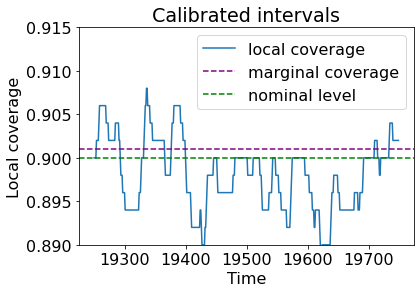

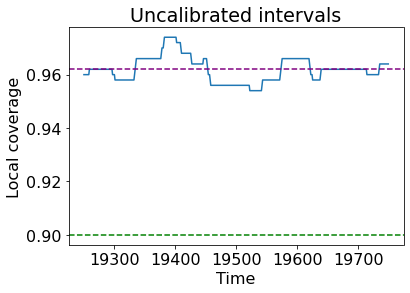

*Note: the marginal coverage here is computed over only the last 1000 samples


In [13]:
def display_local_coverage(timestamps, intervals,
                          display_legend=True, y_lim=True, title=None):
    y_test = dataset.unscaled_y.cpu().squeeze()[timestamps]
    predicted_intervals = intervals.unscaled_intervals.squeeze()
    lower_pred, upper_pred = predicted_intervals[:, 0].cpu(), predicted_intervals[:, 1].cpu()

    coverages = ((y_test <= upper_pred) & (y_test >= lower_pred)).float()
    local_coverages = []
    for i in range(250, len(timestamps) - 250):
        local_coverages.append(coverages[i-250:i+250].mean().item())
    marginal_coverage = coverages.mean().item()

    plt.plot(timestamps[250:-250], local_coverages, label='local coverage')
    plt.axhline(y=marginal_coverage, linestyle='--', color='purple', label='marginal coverage')
    plt.axhline(y=1-alpha, linestyle='--', color='green', label='nominal level')
    if display_legend:
        plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Local coverage")
    if y_lim:
        plt.ylim(0.89, 0.915)
    if title is not None:
        plt.title(title)
    plt.show()

size = 1000
timestamps = test_timestamps[-size:]
display_local_coverage(timestamps, calibrated_intervals[-size:], title="Calibrated intervals")
display_local_coverage(timestamps, uncalibrated_intervals[-size:], display_legend = False, y_lim = False, 
                       title="Uncalibrated intervals")

print(f"*Note: the marginal coverage here is computed over only the last {size} samples")

# Controlling a different risk! -- The Miscoverage Counter (MC)

In [14]:
mc_alpha = 0.1 / (1-0.1)
mc_loss = MiscoverageCounterLoss()

In [15]:
model = OnlineQR(dataset.x_dim, dataset.y_dim,
                     lstm_hidden_size=lstm_hidden_size,
                     lstm_layers=lstm_layers, lstm_in_layers=lstm_in_layers,
                     lstm_out_layers=lstm_out_layers, dropout=dropout,
                     lr=lr, wd=wd, device=device, non_linearity=non_linearity,
                     backward_size=backward_size, train_all_q=train_all_q,
                     alpha=alpha, batch_size=bs)

set_constructing_function = PredictionIntervalConstructingFunctionWithCQR(stretching)
calibration_scheme = RollingRiskControl(0.1, mc_alpha, set_constructing_function, mc_loss)

In [16]:
train_timestamps, validation_timestamps, test_timestamps = dataset.get_data_timestamps()

print("Running on training set...")
online_inference(model, calibration_scheme, dataset, train_timestamps, device)
print("Running on validation set...")
online_inference(model, calibration_scheme, dataset, validation_timestamps, device)
if isinstance(calibration_scheme, ParameterFreeOnlineCalibration):
    calibration_scheme.set_hyperparameters_on_validation_set(validation_timestamps)
print("Running on test set...")
mc_calibrated_intervals, mc_uncalibrated_intervals = online_inference(model, calibration_scheme, dataset, test_timestamps,
                 device)

mc_uncalibrated_predictions = PredictionIntervalsCollection(len(test_timestamps), dataset.scaler, device)
for interval in mc_uncalibrated_intervals:
    mc_uncalibrated_predictions.add_uncertainty_sets(PredictionInterval(interval.intervals))
mc_uncalibrated_intervals = mc_uncalibrated_predictions

  0%|                                                                               | 10/12000 [00:00<02:10, 91.79it/s]

Running on training set...


  0%|▏                                                                               | 10/4000 [00:00<00:44, 89.94it/s]

Running on validation set...


  0%|▏                                                                                | 9/4000 [00:00<00:48, 81.76it/s]

Running on test set...


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:45<00:00, 87.90it/s]


## Compute metrics -- MC Calibration

In [17]:
compute_metrics(dataset, test_timestamps, mc_calibrated_intervals, mc_uncalibrated_intervals, mc_loss, mc_alpha)

| Method       |   Empirical risk |   Nominal level |   Average length |   Miscoverage streak length |
|--------------+------------------+-----------------+------------------+-----------------------------|
| RRC          |          0.111   |        0.111111 |          1102.69 |                     1.20257 |
| Uncalibrated |          0.21775 |        0.111111 |          1126.13 |                     2.93407 |


## Visualize results -- MC Calibration

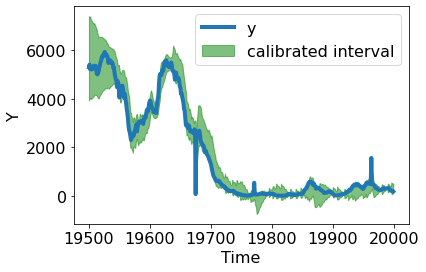

In [18]:
size = 500
timestamps = test_timestamps[-size:]
visualize_results(dataset, timestamps, mc_calibrated_intervals[-size:])

## Calibrated (green) vs uncalibrated intervals (blue) -- MC Calibration

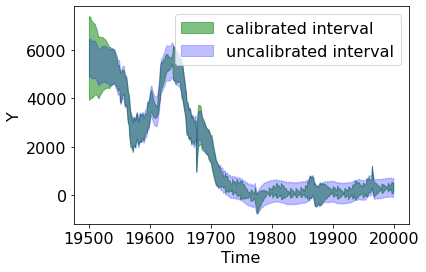

In [19]:
size = 500
timestamps = test_timestamps[-size:]
visualize_intervals_comparison(dataset, timestamps, mc_calibrated_intervals[-size:], mc_uncalibrated_intervals[-size:])